## Podium Review Summarization: Turning Reviews into Action Items

This Jupyter notebook provides documentation for the aspect extraction code.

## Loading the Data
Below, we read the review data into a Pandas dataframe and drop any rows containing missing values.

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.summarization import summarize, keywords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.word2vec import Word2Vec
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as mp
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import random
import string
import nltk
import re

%matplotlib inline

# Read data from csv file
df = pd.read_csv('/Users/degravek/Insight/project/reviews10000.csv', header=0)
df.rename(columns={'Rating': 'rating', 'Review Text': 'text', 'Location Id': 'location',
                    'Publish Date': 'date', 'Industry': 'industry'}, inplace=True)

# For speed purposes, we can cut the dataframe down
df = df[:10000]

# Drop rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

We can then define several functions that will be used later in the code. These include functions to strip punctuation, stem and lemmatize words, compute n-grams, and extract noun-phrases. The function used to extract noun-phrases takes in a "grammar" argument that looks something like: grammar = 'CHUNK: {<JJ.*>*<NN.*>+}'. The string of text between curly braces determines which parts of speech will be searched for when the function is called. In this case it's zero or more optional adjectives followed by one or more nouns. This configuration seems to work well, but can be changed to others depending on the problem and what kinds of speech patterns you're interested in finding.

In [6]:
# Remove some punctuation when summarizing reviews
def process(text):
    result = text.replace('/', '').replace('\n', '')
    result = re.sub(r'\.+', '  ', result)
    result = re.sub(r'\!+', '  ', result)
    result = re.sub(r'(.)\1{2,}', r'\1', result)
    result = re.sub(r'\W+', ' ', result).strip()
    result = result + '.'
    return result

# Strip punctuation from the data
def strip_punctuation(text):
    result = ''.join(tmp for tmp in text if tmp not in punctuation)
    result = re.sub(' +',' ', result)
    result = result.lower().strip()
    return result

# Define the Porter stemmer in case we want to use it
porter = PorterStemmer()
def tokenizer_porter(text):
    result = [porter.stem(word) for word in text.split()]
    result = ' '.join(result)
    return result

# Define a function to remove stop words
stop = stopwords.words('english')
def rmstopwords(text):
    result = text.split()
    result = ' '.join(word for word in result if word not in stop)
    return result

# Define a function to lemmatize words
lem = WordNetLemmatizer()
def lemmatize(text):
    result = text.split()
    result = ' '.join(lem.lemmatize(word)for word in result if word not in stop)
    return result

# Define a function to break reviews into individual sentences
def tokenizetext(text):
    sentences = nltk.sent_tokenize(text)
    sentences = [[sent] for sent in sentences]
    return sentences

# Define a function to find n-grams quickly
# If looking for unigrams, make sure they're nouns
def ngrams(text, n):
    result = []
    text = text.split()
    if n==1:
        text = nltk.pos_tag(text)
        result = [word for word, pos in text if pos[0] == 'N']
    else:
        for i in range(len(text)-n+1):
            result.append('_'.join(text[i:i+n]))
    return result

# Define a function to extract noun-phrase chunks of text
# This chunking pattern looks for an optional series of
# adjectives followed by one or more nouns
def extract_candidate_chunks(text, grammar = 'CHUNK: {<JJ.*>*<NN.*>+}'):
    import itertools, nltk, string
    parser = nltk.RegexpParser(grammar)
    tagged_sents = [nltk.pos_tag(nltk.word_tokenize(text))]

    for chunk in tagged_sents:
        if not chunk:
            candidates = []
        else:
            candidates = []
            tree = parser.parse(chunk)
            for subtree in tree.subtrees():
                if subtree.label() == 'CHUNK':
                    candidates.append((' '.join([a for (a,b) in subtree.leaves()])))
    candidates = [word for word in candidates if word not in stop]
    return candidates

## Process the Data

The function ProcessData below does the bulk of the text analysis. It takes in the original dataframe as well as an argument called "ptype". Argument "ptype" can be set to either "ngram", "chunk", or "rake" depending on whether you want to compute n-grams or noun-phrase chunks defined by the functions above, or if you want to use an alternative extraction method called Rapid Keyword Extraction (RAKE). The RAKE algorithm extracts keywords from text by identifying runs of non-stopwords and then scoring the phrases across the document. The only input to the algorithm aside from the review text is a list of stop words. To get and use the algorithm, there are a few things we have to do:

* Clone the repository here https://github.com/zelandiya/RAKE-tutorial
* Add the path to that repository to "rake_path" in the code snippet above ProcessData
* Feed RAKE a list of sentences where punctuation and stop words have not been removed

The RAKE tutorial can be found here https://www.airpair.com/nlp/keyword-extraction-tutorial.

Below, we define the path to the rake algorithm.

In [7]:
# Add the path to where RAKE was downloaded
rake_path = '/Users/degravek/Downloads/RAKE-tutorial-master/'
import sys
sys.path.insert(0, rake_path)
import rake, operator

# RAKE will look for key phrases with
# at least four characters, composed
# of at most 3 words, appearing in the
# text at least one time
rake_object = rake.Rake(rake_path + 'SmartStoplist.txt', 4, 3, 1)

If running ProcessData using n-grams, you must input a tuple containing the "n" value that you want to use. For example, if one wants to isolate bigrams, use ('ngram', 2).

The first thing function ProcessData does is to divide all reviews into a list of individual sentences. We then initialize a sentiment analyzer which will determine the sentiment of any sentences where possible key words of interest are identified. The sentiment analyzer used here is called VADER, and seems to be pretty robust.

The outer for-loop loops over each review, one at a time. For each sentence in the review, the inner for loop strips punctuation, makes the text lower-case, and strips white spaces. Stop words are removed, and the remaining words are lemmatized. Depending on the choice of "ptype", functions are then called to find n-grams, noun-phrase chunks, or to use RAKE. Whenever an n-gram, noun-phrase chunk, etc. is found, the sentiment analyzer takes in the *original*, unprocessed sentence and computes the sentiment polarity score of it. The sentiment analyzer actually outputs four values - a negative polarity score, a positive polarity score, a neutral polarity score, and a compound score (sort of like a representative average of the three). We choose to use the compound score here. Then, for each aspect found, we append additional information of interest from the original dataframe. That way, for each aspect, we have the corresponding sentence from which it came, along with a sentiment score. We also include here the accompanying star rating of the original review from which the sentence came, as well as the corresponding date and location information. All of this is then put into a single dataframe at the bottom.

In [8]:
def ProcessData(df, ptype):
    parse_type = ptype

    # Divide reviews into individual sentences
    sentences = df['text'].apply(tokenizetext)

    # Stick the sentences back into the dataframe
    df['sentlist'] = sentences
    d1, d2, d3 = [], [], []
    d4, d5, d6 = [], [], []

    # Initialize the sentiment vader analyzer
    sid = SentimentIntensityAnalyzer()

    # Loop over sentences and process them
    for i in range(0, df.shape[0]):
        sent_list = df['sentlist'][i]
        for sentence in sent_list:
            sent_raw = ''.join(sentence)
            sent_pro = strip_punctuation(sent_raw)
            sent_pro = rmstopwords(sent_pro)
            sent_pro = lemmatize(sent_pro)
            sentiment = sid.polarity_scores(sent_raw)['compound']
            if parse_type[0] == 'ngram':
                pos = ngrams(sent_pro, ptype[1])
            elif parse_type == 'chunk':
                pos = extract_candidate_chunks(sent_pro)
            elif parse_type == 'rake':
                pos = rake_object.run(sent_raw)
                pos = [word[0] for word in pos]
            for j in pos:
                d1.append(df['date'][i])
                d2.append(df['location'][i])
                d3.append(df['rating'][i])
                d4.append(j),
                d5.append(sentiment)
                d6.append(sent_raw)

    # Put everything in a dataframe
    matrix = pd.DataFrame()
    matrix['date']      = d1
    matrix['location']  = d2
    matrix['rating']    = d3
    matrix['aspects']   = d4
    matrix['sentiment'] = d5
    matrix['context']   = d6

    # Remove any entry where the sentence
    # was determined to be neutral
    matrix = matrix[(matrix['sentiment'] != 0)]
    return matrix

Below, we can call the function ProcessData to grab n-grams, noun-phrase chunks, and use the RAKE algorithm.

In [9]:
matrix_rake = ProcessData(df, 'rake')
matrix_chunk = ProcessData(df, 'chunk')
matrix_ngram1 = ProcessData(df, ('ngram',1))
matrix_ngram2 = ProcessData(df, ('ngram',2))
matrix_ngram3 = ProcessData(df, ('ngram',3))

Let's look at the contents of matrix_rake.

In [6]:
matrix_chunk.head()

,date,location,rating,aspects,sentiment,context
1,2017-01-14 12:00:00,7684,5.0,sumler,0.3612,Anne Sumler listened to understand my needs an...
2,2017-01-14 12:00:00,7684,5.0,understand need,0.3612,Anne Sumler listened to understand my needs an...
3,2017-01-14 12:00:00,7684,5.0,car fit need,0.3612,Anne Sumler listened to understand my needs an...
4,2017-01-14 12:00:00,7684,5.0,busy time look vehicle,-0.1027,I was too busy at the time to look at the vehi...
5,2017-01-14 12:00:00,7684,5.0,vehicle business check,-0.1027,I was too busy at the time to look at the vehi...


# Sort the Data by Counts, Sentiment, or Importance

Now that we have a list of aspects (unigrams, bigrams, noun-phrase chunks, etc.), we can try and find the most interesting ones (i.e., those associated with a high or low sentiment value). Below, we define a function called SortMatrix that does this.

SortMatrix takes in the output dataframe from ProcessData, groups it by aspect, and computes

* Aspect frequency (the number of times the aspect appears in the results)
* The mean senitment score for each aspect across all mentions
* A weighted sum of sentiment score for each aspect across all mentions

In the function SortMatrix, these are placed in the columns "counts", "sent_mean", and "importance" respectively. For "importance", my thought was that an aspect that occurs more frequently is more likely to be imporant, but the sum of sentiment for that aspect might need to be weighted in some way. For example, say we assume the aspect "car" appears 1,000 times, and each time has only a weak positive sentiment score of 0.1. And say we also assume the aspect "service" appears 50 times, but always has a very strong positive sentiment score of 1.0. Even though "service" is much more highly rated than "car", summing the sentiment score will lead to "car" being placed above "service". However, if we weight the sum by the number of counts in some way, we can force more highly rated aspects with less counts to be placed higher up on the importance list. SortedMatrix uses the function

$$\mathrm{importance}\,(\,i\,) = \frac{\sum_j \mathrm{sentiment}\,(\,i\,)}{\mathrm{counts}\,(\,i\,)^{n}},$$

where the weighted sum (i.e., the "importance") of aspect $i$ is equal to it's sentiment sum over all occurrences $(\,j\,)$ divided by its frequency to some power $n$. The variable $n$ is currently set to 0.1 in SortedMatrix, but you can change it to whatever you like.

In [10]:
def SortMatrix(in_matrix, rfilter=None):
    if rfilter:
        in_matrix = in_matrix[in_matrix['rating'].isin(rfilter)].copy()

    in_matrix['counts'] = in_matrix.groupby(['aspects'])['sentiment'].transform('count')
    group1 = in_matrix.groupby(['aspects'])['sentiment'].sum()
    group2 = in_matrix.groupby(['aspects'])['counts'].mean()
    group3 = in_matrix.groupby(['aspects'])['sentiment'].mean()
    sorted_mat = pd.DataFrame()
    #sorted_mat['sent_sum']   = np.round(group1, 2)
    sorted_mat['counts']     = group2
    sorted_mat['frac']       = np.round(100*(group2/group2.sum()), 2)
    sorted_mat['sent_mean']  = np.round(group3, 2)
    sorted_mat['importance'] = np.round(group1/(group2**0.1), 2)
    sorted_mat = sorted_mat.sort_values('importance', ascending=False)
    sorted_mat.reset_index(level=0, inplace=True)
    return sorted_mat

Let's feed the dataframes computed above into SortMatrix.

In [11]:
sorted_rake = SortMatrix(matrix_rake)
sorted_chunk = SortMatrix(matrix_chunk)
sorted_ngram1 = SortMatrix(matrix_ngram1)
sorted_ngram2 = SortMatrix(matrix_ngram2)
sorted_ngram3 = SortMatrix(matrix_ngram3)

Let's look at the contents of sorted_chunk.

In [9]:
sorted_chunk.head()

,aspects,counts,frac,sent_mean,importance
0,car,1058,1.45,0.37,196.11
1,thanks,544,0.75,0.60,174.08
2,vehicle,559,0.77,0.40,119.31
3,courtesy chevrolet,356,0.49,0.57,112.13
4,thank,349,0.48,0.51,99.21


SortMatrix also allows one to filer results by star rating. For example, if we only want to see aspects from the 1 and 2 star rated reviews, we can call

In [10]:
filtered_rake = SortMatrix(matrix_rake, rfilter=[1,2])

filtered_rake.head()

,aspects,counts,frac,sent_mean,importance
0,courtesy,65,0.31,0.36,15.21
1,courtesy chevrolet,58,0.28,0.32,12.41
2,hope,31,0.15,0.52,11.44
3,good,50,0.24,0.33,11.00
4,wanted,60,0.29,0.26,10.17


We can print the ten highest and lowest rated aspected sorted by importance.

In [12]:
print(sorted_rake.head().append(sorted_rake.tail()), '\n')
print(sorted_chunk.head().append(sorted_chunk.tail()), '\n')
print(sorted_ngram1.head().append(sorted_ngram1.tail()), '\n')
print(sorted_ngram2.head().append(sorted_ngram2.tail()), '\n')
print(sorted_ngram3.head().append(sorted_ngram3.tail()), '\n')

                  aspects  counts  frac  sent_mean  importance
0                friendly     989  0.75       0.69      343.92
1                 helpful    1039  0.79       0.66      340.84
2                   great     883  0.67       0.70      315.61
3                 vehicle    1555  1.19       0.41      307.51
4      courtesy chevrolet     956  0.73       0.59      284.19
25871            problems     122  0.09      -0.16      -12.26
25872            horrible      40  0.03      -0.55      -15.27
25873               wrong      95  0.07      -0.27      -16.55
25874                rude      63  0.05      -0.46      -19.04
25875             problem     277  0.21      -0.18      -27.77 

                  aspects  counts  frac  sent_mean  importance
0                     car    1058  1.45       0.37      196.11
1                  thanks     544  0.75       0.60      174.08
2                 vehicle     559  0.77       0.40      119.31
3      courtesy chevrolet     356  0.49       0.57   

### Creating and Searching for Key Aspects

Now that we've identified some aspects, we can search for and summarize them. The code below takes in two sets of aspects: static ones supplied by the user, as well as dynamic ones identified on the fly by the ProcessData and SortedMatrix functions above. The user-supplied static aspects *must* be contained in whichever dataframe you're searching for them (in matrix_chunk, or in matrix_ngram1, etc.), otherwise an error will occur.

The piece of code below takes the user-supplied static aspects "value" and "service", as well as the top 3 dynamically-chosen ones, and just sorts them by the number of times they appear in dtaframe matrix_ngram1 just so that they're combined into one list of aspects.

In [14]:
# Input two static aspects, and grab the top
# three dynamic ones from sorted_ngram1
static_aspects  = ['value', 'service']
dynamic_aspects = sorted_ngram1['aspects'][:3] # Choose three dynamic aspects

# Aspects above are unigrams, so use matrix_ngram1
# Sort them by their frequency in matrix_ngram1
count = Counter(matrix_ngram1['aspects'])
s = [(x, count[x]) for x in static_aspects]
s = sorted(s, key=lambda x: x[1], reverse=True)
d = [(x, count[x]) for x in dynamic_aspects]
d = sorted(d, key=lambda x: x[1], reverse=True)

seen = set()
seen_add = seen.add
merged = s + d
merged = [x for x in merged if not (x in seen or seen_add(x))]

# Get a final list of aspects
aspects = list([ii for ii in zip(*merged)][0])

### Text Summarization

Now that we have our list of aspects, we can try to summarize them. If the text were structured nicely, we could just use gensim's "summarize" function to do this. However, summarizing the unstructured review text has turned out to be really difficult, as many reviews are not very long, and each review may talk about several different things.

Instead, we can attempt to "summarize" the text by randomly sampling sentences in which the aspects occur. This random sampling attempts to give a representative few sentences for each aspect, but of course this can be done other ways depending on your own preferences. The SummarizeReviews function below grabs these representative sentences. It also computes a "star rating" for each aspect. The star rating is computed by calculating the mean sentiment for a given aspect and linearly stransforming the value to the range [1, 5].

In [15]:
def SummarizeReviews(matrix, aspect_list, n_statements):
    # Try to summarize the aspects
    star_rating, summary = [], []
    for i, aspect in enumerate(aspect_list):
        rating = matrix.groupby('aspects')['sentiment'].mean().sort_values(ascending=False)[aspect]
        star_rating.append((rating - (-1))*(5 - 1)/(1 - (-1)) + 1)

        # Try to process the text a little bit
        corpus = pd.DataFrame()
        corpus['text'] = matrix[(matrix['aspects']==aspect)].sort_values('sentiment', ascending=False)['context']
        #corpus = corpus.head(num).append(corpus.tail(num))
        corpus = corpus.sample(n=n_statements)
        corpus = list(corpus['text'].apply(process))
        print('ASPECT: ', aspect)
        print('STAR: ', star_rating[i])
        print('SUMMARY: ', corpus)
        print('\n')
    return corpus

To call this function, the user must supply the dataframe to be searched (in this case it's matrix_ngram1), as well as a list of aspects, and the number of representative sentences to be returned. The SummarizeReviews function is called below.

In [16]:
summary = SummarizeReviews(matrix_ngram1, aspects, 5)

ASPECT:  service
STAR:  3.97588773585
SUMMARY:  ['Bryan Gunter is a very professional and friendly service representative.', 'Tim always makes a routine service appointment or a last minute service appointment easy and uncomplicated because he is trustworthy and professional.', 'Excellent customer ServiceI scheduled my car for service on 92115 and Faye is my service advisor.', 'She and I were happy with Christian s customer service and how he approaches customers.', 'Michael Lesko has been my salesman for 5 years and he provides excellent customer service each time I come to the dealership.']


ASPECT:  value
STAR:  4.07348905109
SUMMARY:  ['The deal was excellent with a fair trade in value for my old car.', 'Yes PittsburghI drove 130 miles into Cleveland enemy territory from Pittsburgh to take advantage of Motorcars Honda s spectacular value.', 'They gave me a great price for my trade in and the new car came in priced at private party blue book value.', 'I feel confident that we attai

### Using RAKE and the Star Rating to Extract  Keywords

We can also use the star ratings along with RAKE to extract keywords.

In [21]:
# Add the path to where RAKE was downloaded
rake_path = '/Users/degravek/Downloads/RAKE-tutorial-master/'
import sys
sys.path.insert(0, rake_path)
import rake, operator

# RAKE will look for key phrases with
# at least four characters, composed
# of at most 3 words, appearing in the
# test at least one time
rake_object = rake.Rake(rake_path + 'SmartStoplist.txt', 4, 3, 5)

# Divide reviews into positive and negative groups
reviews_top = df[df['rating'] >= 4]['text']
reviews_bot = df[df['rating'] <= 2]['text']

# Join the sentences into a list
list_top = ' '.join(reviews_top)
list_bot = ' '.join(reviews_bot)

# Apply RAKE to them
score_top = rake_object.run(list_top)
score_bot = rake_object.run(list_bot)

# Get the aspects by themselves
aspects_top = [item[0] for item in score_top]
aspects_bot = [item[0] for item in score_bot]

# Put them in a dataframe and grab the top ones
revrank = pd.DataFrame()
revrank['positive_aspects'] = aspects_top[:15]
revrank['negative_aspects'] = aspects_bot[:15]

If RAKE is run on more than a few thousand reviews, it will take some time. The output for the auto reviews will look something like

In [34]:
print(revrank.head(15))

             positive_aspects           negative_aspects
0            shana del grosso      poor customer service
1                  big sky rv          simple oil change
2     customer service skills     worst customer service
3          routine oil change  terrible customer service
4           car sales manager           long story short
5          crown toyota scion  horrible customer service
6             great sales man         check engine light
7             free oil change                  brake pad
8               free car wash         walked back inside
9   customer service oriented             service writer
10           car sales person             san bernardino
11       highly recommend tim                  sales man
12   customer service manager                  sales rep
13  internet sales department                cooper tire
14       scheduled oil change                  gas cards


### Visually Explore the Data

Below are a couple of ways to explore the data that I've found useful. The function PlotReviewBars makes bar plots of aspect importance for the best and worst features that the algorithm has identified.

In [35]:
def PlotReviewBars(sorted_ngram1, sorted_ngram2, sorted_ngram3, n):
    fig1 = mp.figure()
    font_value = 8
    r = sorted_ngram1.head(n).append(sorted_ngram1.tail(n))
    r.plot.bar(x='aspects', y='importance', figsize=(9,3))
    mp.ylabel('Sum of Sentiment', fontsize=font_value)
    mp.xlabel('Aspects', fontsize=font_value)
    mp.title('Aspects by Weighted Sum of Sentiment',  fontsize=font_value)
    mp.tick_params(axis='both', which='major', labelsize=font_value)

    fig2 = mp.figure()
    r = sorted_ngram2.head(n).append(sorted_ngram2.tail(n))
    r.plot.bar(x='aspects', y='importance', figsize=(9,3))
    mp.ylabel('Sum of Sentiment', fontsize=font_value)
    mp.xlabel('Aspects', fontsize=font_value)
    mp.title('Aspects by Weighted Sum of Sentiment',  fontsize=font_value)
    mp.tick_params(axis='both', which='major', labelsize=font_value)

    fig3 = mp.figure()
    r = sorted_ngram3.head(n).append(sorted_ngram3.tail(n))
    r.plot.bar(x='aspects', y='importance', figsize=(9,3))
    mp.ylabel('Sum of Sentiment', fontsize=font_value)
    mp.xlabel('Aspects', fontsize=font_value)
    mp.title('Aspects by Weighted Sum of Sentiment',  fontsize=font_value)
    mp.tick_params(axis='both', which='major', labelsize=font_value)
    return fig1, fig2, fig3

Let's make some bar plots using sorted_ngram1, sorted_ngram2, and sorted_ngram3.

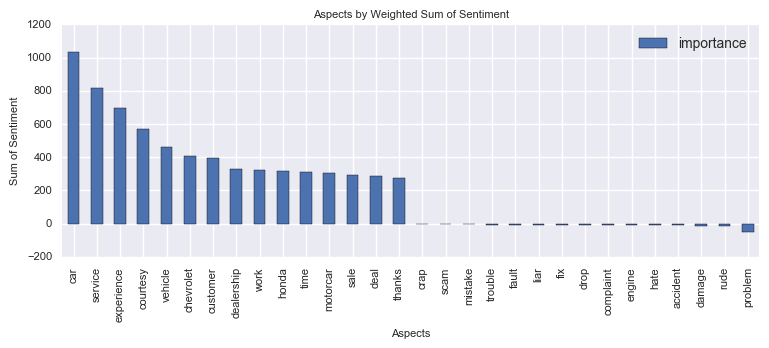

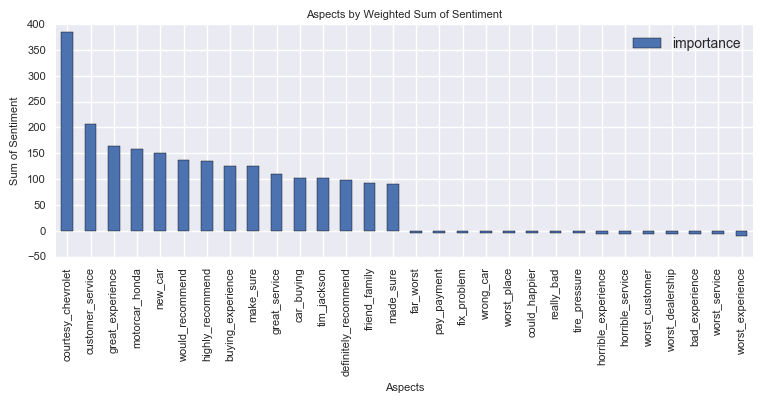

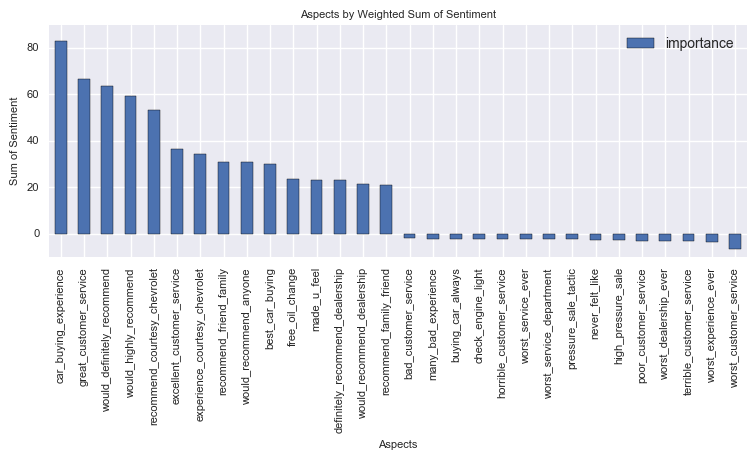

In [36]:
d = PlotReviewBars(sorted_ngram1, sorted_ngram2, sorted_ngram3, 15)

We can also plot a word cloud of aspects using the function PlotWordCloud below. The function allows us to plot polarized aspects by passing it an argument of 'neg' or 'pos'. If no argument is given, all aspects are plotted.

In [37]:
def PlotWordCloud(matrix, sent=None):
    if sent == 'pos':
        words = ' '.join(matrix[matrix['sentiment']>0]['aspects'])
    elif sent == 'neg':
        words = ' '.join(matrix[matrix['sentiment']<0]['aspects'])
    else:
        words = ' '.join(matrix['words'])

    mp.figure(figsize=(8,12))
    wordcloud = WordCloud(max_words=100, background_color='white').generate(words)
    mp.imshow(wordcloud)
    mp.axis('off')

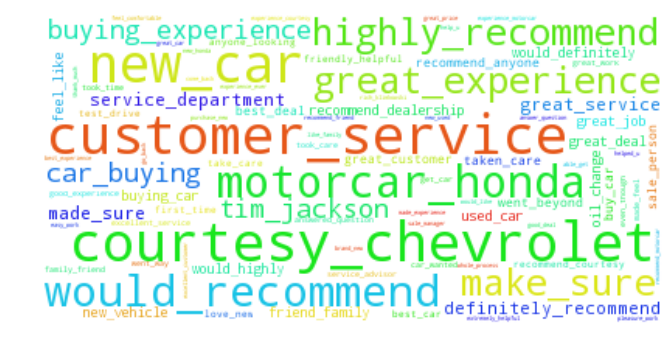

In [38]:
p = PlotWordCloud(matrix_ngram2, 'pos')

Another useful way of identifying interesting aspects is to cluster the data. We can do that nicely using Word2Vec. Word2vec produces a numerical vector for each aspect such that similar words appear close to each other in vector space. We can do that for a portion of the auto data with the script below.

Word2Vec relies on a very large set of pre-trained word vectors trained on around 100 billion words. These word vectors are necessary for the plot we want to make and can be found under "pre-trained word and phrase vectors" here: https://code.google.com/archive/p/word2vec/. The file is called "GoogleNews-vectors-negative300.bin".

In [39]:
# Load Google data file
model = Word2Vec.load_word2vec_format('/Users/degravek/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

Now that the word vectors are loaded, let's plot the 500 most frequently occuring words in matrix_ngram1.

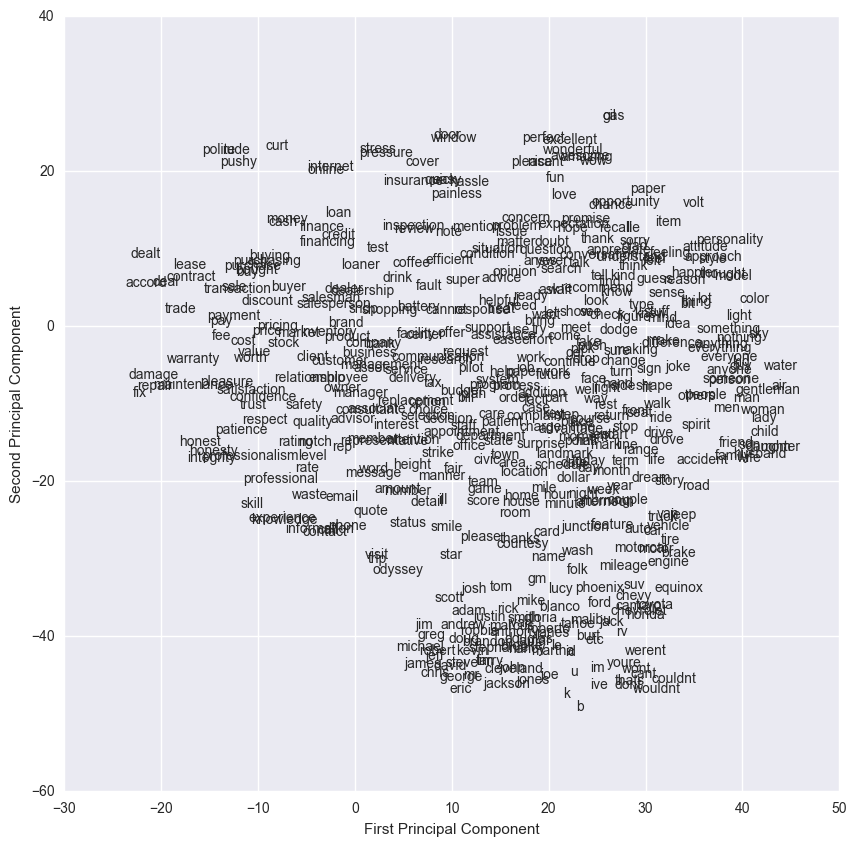

In [40]:
# Get the top 500 most frequently occuring
# words from the matrix_ngram1 dataframe
s = matrix_ngram1['aspects'].value_counts()[:500].index.tolist()

# Define a function which looks for each
# of these words in the Google file
# and returns their word embedding vector
def getWordVecs(words):
    wvec, vecs = [], []
    for word in words:
        try:
            vecs.append(model[word].reshape((1,300)))
        except KeyError:
            continue
        wvec.append(word)
    vecs = np.concatenate(vecs)
    # TSNE expects float type values
    return wvec, np.array(vecs, dtype='float')

# Get the word embedding vectors
# from the Google data file
wvec, fitvec = getWordVecs(s)

# Call TSNE to transform the word
# embeddings to two dimensions
tsne = TSNE(2)
resvec = tsne.fit_transform(fitvec)

# x is the first principal component
# y is the sencond principle component
x = resvec[:,0]
y = resvec[:,1]

# Plot the words in vector space
fig, ax = mp.subplots(figsize = (10,10))
mp.scatter(x, y, facecolors='none', edgecolors='none')

for i, txt in enumerate(wvec):
    mp.annotate(txt, (x[i],y[i]))
mp.xlabel('First Principal Component')
mp.ylabel('Second Principal Component')

One will notice that this plot won't look exactly the same if the code is re-run. This is just due to some randomness in the data reduction performed by TSNE. However, as we can see, many names (scott, josh, joe, etc.) are always clustered together. Often times a customer writing a review (either positive or negative) will refer to the salesperson they worked by name. This suggests that a dictionary would be helpful to map these names to, for example, a single term "staff".